# Data Validation: Raw → Interim → Processed

**Purpose**: Validate the complete data loading pipeline to ensure all transformations are correct before model training.

**Pipeline Steps**:
1. ✅ Raw data ingestion
2. ✅ Interim data (state, master) 
3. ✅ EDA processing (demand_long)
4. ✅ Stockout imputation
5. ✅ Data cleaning & winsorization

**Date**: February 2, 2026  
**Project**: VN2 Inventory Optimization

## 1. Import Required Libraries

In [3]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from rich import print as rprint
from IPython.display import display, HTML

# VN2 modules
from vn2.data import submission_index, load_initial_state, load_sales, load_master

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries loaded successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ Libraries loaded successfully!
Pandas version: 2.3.3
NumPy version: 2.4.1


## 2. Load Raw Data

Raw data from competition files in `data/raw/`

In [4]:
raw_path = Path('../data/raw')

print("📁 Loading raw data files...")
print("=" * 70)

# 1. Submission index (SKU list)
idx = submission_index(str(raw_path))
print(f"✓ Submission Index: {len(idx):,} SKUs")
print(f"  Index type: {type(idx).__name__}")
print(f"  Levels: {idx.names}")

# 2. Initial state (inventory)
state_raw = load_initial_state(str(raw_path), idx)
print(f"\n✓ Initial State: {state_raw.shape}")
print(f"  Columns: {list(state_raw.columns)}")
print(f"  Total inventory: {state_raw['on_hand'].sum():,.0f} units")

# 3. Master data (hierarchy)
master_raw = load_master(str(raw_path))
print(f"\n✓ Master Data: {master_raw.shape}")
print(f"  Columns: {list(master_raw.columns)}")

# 4. Sales history (wide format)
sales_raw = load_sales(str(raw_path))
print(f"\n✓ Sales Data: {sales_raw.shape}")
date_cols = [c for c in sales_raw.columns if c not in ['Store', 'Product']]
print(f"  Date columns: {len(date_cols)} weeks")
print(f"  Date range: {date_cols[0]} to {date_cols[-1]}")

print("\n" + "=" * 70)
print("✅ All raw data files loaded successfully!")

📁 Loading raw data files...
✓ Submission Index: 599 SKUs
  Index type: MultiIndex
  Levels: ['Store', 'Product']

✓ Initial State: (599, 3)
  Columns: ['on_hand', 'intransit_1', 'intransit_2']
  Total inventory: 599 units

✓ Master Data: (599, 6)
  Columns: ['ProductGroup', 'Division', 'Department', 'DepartmentGroup', 'StoreFormat', 'Format']

✓ Sales Data: (599, 159)
  Date columns: 157 weeks
  Date range: 2021-04-12 to 2024-04-08

✅ All raw data files loaded successfully!


In [5]:
# Preview raw sales data (first few SKUs and weeks)
print("📊 Raw Sales Preview (first 5 SKUs, first 10 weeks):\n")
preview_cols = ['Store', 'Product'] + date_cols[:10]
display(sales_raw[preview_cols].head())

# Sales statistics
sales_matrix = sales_raw[date_cols].values
print(f"\n📈 Raw Sales Statistics:")
print(f"  Total sales: {sales_matrix.sum():,.0f} units")
print(f"  Mean weekly sales per SKU: {sales_matrix.mean():.2f} units")
print(f"  Median weekly sales: {np.median(sales_matrix):.2f} units")
print(f"  Zero sales: {(sales_matrix == 0).sum():,} observations ({(sales_matrix == 0).mean()*100:.1f}%)")
print(f"  Max single week: {sales_matrix.max():.0f} units")

📊 Raw Sales Preview (first 5 SKUs, first 10 weeks):



,Store,Product,2021-04-12,2021-04-19,2021-04-26,2021-05-03,2021-05-10,2021-05-17,2021-05-24,2021-05-31,2021-06-07,2021-06-14
0,0,126,0.00,0.00,3.00,3.00,0.00,1.00,1.00,0.00,1.00,0.00
1,0,182,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1,124,13.00,4.00,10.00,5.00,1.00,2.00,3.00,4.00,2.00,1.00
3,2,124,5.00,5.00,12.00,16.00,10.00,8.00,10.00,9.00,7.00,10.00
4,2,126,0.00,0.00,6.00,5.00,7.00,4.00,1.00,2.00,6.00,5.00



📈 Raw Sales Statistics:
  Total sales: 276,648 units
  Mean weekly sales per SKU: 2.94 units
  Median weekly sales: 1.00 units
  Zero sales: 40,614 observations (43.2%)
  Max single week: 494 units


## 3. Load Interim Data (Post-Ingestion)

After running `./go ingest`, data is saved as parquet in `data/interim/`

In [6]:
interim_path = Path('../data/interim')

print("📁 Loading interim data files...")
print("=" * 70)

# Load parquet files
state_interim = pd.read_parquet(interim_path / 'state.parquet')
master_interim = pd.read_parquet(interim_path / 'master.parquet')

print(f"✓ State (interim): {state_interim.shape}")
print(f"  Columns: {list(state_interim.columns)}")
print(f"  Index: {state_interim.index.names}")

print(f"\n✓ Master (interim): {master_interim.shape}")
print(f"  Columns: {list(master_interim.columns)}")
print(f"  Index: {master_interim.index.names}")

# Validate: should match raw data
assert state_interim.shape == state_raw.shape, "State shape mismatch!"
assert master_interim.shape == master_raw.shape, "Master shape mismatch!"
assert (state_interim.index == state_raw.index).all(), "State index mismatch!"

print("\n" + "=" * 70)
print("✅ Interim data validated: matches raw data!")

📁 Loading interim data files...
✓ State (interim): (599, 3)
  Columns: ['on_hand', 'intransit_1', 'intransit_2']
  Index: ['Store', 'Product']

✓ Master (interim): (599, 6)
  Columns: ['ProductGroup', 'Division', 'Department', 'DepartmentGroup', 'StoreFormat', 'Format']
  Index: ['Store', 'Product']

✅ Interim data validated: matches raw data!


## 4. Load Processed Data (Post-EDA)

After EDA notebook, data is transformed to long format with stockout detection.

In [7]:
processed_path = Path('../data/processed')

print("📁 Loading processed data files...")
print("=" * 70)

# Load demand_long (EDA output)
demand_long = pd.read_parquet(processed_path / 'demand_long.parquet')

print(f"✓ demand_long.parquet: {demand_long.shape}")
print(f"  Columns: {list(demand_long.columns)}")
print(f"  Memory: {demand_long.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Date range
print(f"\n📅 Time Coverage:")
print(f"  Min date: {demand_long['week_date'].min()}")
print(f"  Max date: {demand_long['week_date'].max()}")
print(f"  Unique weeks: {demand_long['week'].nunique()}")
print(f"  Unique SKUs: {len(demand_long.groupby(['Store', 'Product']))}")

# Stockout detection
stockout_obs = (~demand_long['in_stock']).sum()
stockout_pct = (~demand_long['in_stock']).mean() * 100
print(f"\n🚫 Stockout Detection:")
print(f"  Stockout observations: {stockout_obs:,} ({stockout_pct:.1f}%)")
print(f"  In-stock observations: {demand_long['in_stock'].sum():,}")

print("\n" + "=" * 70)
display(demand_long.head(10))

📁 Loading processed data files...
✓ demand_long.parquet: (94043, 15)
  Columns: ['Store', 'Product', 'week', 'sales', 'week_date', 'year', 'retail_week', 'month', 'in_stock', 'ProductGroup', 'Division', 'Department', 'DepartmentGroup', 'StoreFormat', 'Format']
  Memory: 11.48 MB

📅 Time Coverage:
  Min date: 2021-04-12 00:00:00
  Max date: 2024-04-08 00:00:00
  Unique weeks: 157
  Unique SKUs: 599

🚫 Stockout Detection:
  Stockout observations: 10,517 (11.2%)
  In-stock observations: 83,526



,Store,Product,week,sales,week_date,year,retail_week,month,in_stock,ProductGroup,Division,Department,DepartmentGroup,StoreFormat,Format
0,0,126,2021-04-12,0.00,2021-04-12,2021,15,4,True,301202,3012,30,11,1,13
1,0,126,2021-04-19,0.00,2021-04-19,2021,16,4,True,301202,3012,30,11,1,13
2,0,126,2021-04-26,3.00,2021-04-26,2021,17,4,True,301202,3012,30,11,1,13
3,0,126,2021-05-03,3.00,2021-05-03,2021,18,5,True,301202,3012,30,11,1,13
4,0,126,2021-05-10,0.00,2021-05-10,2021,19,5,True,301202,3012,30,11,1,13
5,0,126,2021-05-17,1.00,2021-05-17,2021,20,5,True,301202,3012,30,11,1,13
6,0,126,2021-05-24,1.00,2021-05-24,2021,21,5,True,301202,3012,30,11,1,13
7,0,126,2021-05-31,0.00,2021-05-31,2021,22,5,True,301202,3012,30,11,1,13
8,0,126,2021-06-07,1.00,2021-06-07,2021,23,6,True,301202,3012,30,11,1,13
9,0,126,2021-06-14,0.00,2021-06-14,2021,24,6,True,301202,3012,30,11,1,13


In [8]:
# Load imputed versions
demand_imputed = pd.read_parquet(processed_path / 'demand_imputed.parquet')
demand_winsor = pd.read_parquet(processed_path / 'demand_imputed_winsor.parquet')
demand_capped = pd.read_parquet(processed_path / 'demand_imputed_capped.parquet')

print("📊 Imputed Data Variants:")
print("=" * 70)
print(f"✓ demand_imputed.parquet: {demand_imputed.shape}")
print(f"✓ demand_imputed_winsor.parquet: {demand_winsor.shape}")
print(f"✓ demand_imputed_capped.parquet: {demand_capped.shape}")

# Check for 'imputed' flag
if 'imputed' in demand_imputed.columns:
    n_imputed = demand_imputed['imputed'].sum()
    pct_imputed = demand_imputed['imputed'].mean() * 100
    print(f"\n💉 Imputation Statistics:")
    print(f"  Imputed observations: {n_imputed:,} ({pct_imputed:.1f}%)")
    print(f"  Original observations: {(~demand_imputed['imputed']).sum():,}")
else:
    print("\n⚠️  No 'imputed' flag found in data")

print("\n" + "=" * 70)

📊 Imputed Data Variants:
✓ demand_imputed.parquet: (94043, 17)
✓ demand_imputed_winsor.parquet: (94043, 17)
✓ demand_imputed_capped.parquet: (94043, 17)

💉 Imputation Statistics:
  Imputed observations: 0 (0.0%)
  Original observations: 94,043



## 5. Data Transformation Validation

Verify the transformation from wide (raw) to long (processed) format.

In [9]:
print("🔄 Validating Wide → Long Transformation")
print("=" * 70)

# Raw data dimensions
n_skus_raw = len(sales_raw)
n_weeks_raw = len(date_cols)
expected_rows = n_skus_raw * n_weeks_raw

print(f"Raw Sales (Wide Format):")
print(f"  SKUs: {n_skus_raw:,}")
print(f"  Weeks: {n_weeks_raw}")
print(f"  Expected long rows: {expected_rows:,}")

print(f"\nProcessed (Long Format):")
print(f"  Actual rows: {len(demand_long):,}")
print(f"  Unique SKUs: {len(demand_long.groupby(['Store', 'Product'])):,}")
print(f"  Unique weeks: {demand_long['week'].nunique()}")

# Check if counts match
if len(demand_long) == expected_rows:
    print(f"\n✅ Row count matches! ({len(demand_long):,} rows)")
else:
    diff = expected_rows - len(demand_long)
    print(f"\n⚠️  Row count mismatch: {diff:,} rows difference")
    print(f"   This may be expected if some SKU-week pairs were filtered")

# Verify sales totals match
raw_total = sales_raw[date_cols].sum().sum()
long_total = demand_long['sales'].sum()

print(f"\n💰 Total Sales Verification:")
print(f"  Raw total: {raw_total:,.0f} units")
print(f"  Long total: {long_total:,.0f} units")
print(f"  Difference: {abs(raw_total - long_total):,.0f} units")

if abs(raw_total - long_total) < 1:
    print(f"  ✅ Sales totals match!")
else:
    print(f"  ⚠️  Sales totals differ by {abs(raw_total - long_total):,.0f}")

🔄 Validating Wide → Long Transformation
Raw Sales (Wide Format):
  SKUs: 599
  Weeks: 157
  Expected long rows: 94,043

Processed (Long Format):
  Actual rows: 94,043
  Unique SKUs: 599
  Unique weeks: 157

✅ Row count matches! (94,043 rows)

💰 Total Sales Verification:
  Raw total: 276,648 units
  Long total: 276,648 units
  Difference: 0 units
  ✅ Sales totals match!


## 6. Stockout Detection Validation

Verify that stockouts are correctly identified.

In [10]:
print("🚫 Stockout Analysis")
print("=" * 70)

# Overall stockout rate
stockout_rate = (~demand_long['in_stock']).mean() * 100
print(f"Overall stockout rate: {stockout_rate:.1f}%")

# Stockouts by year
if 'year' in demand_long.columns:
    yearly_stockouts = demand_long.groupby('year')['in_stock'].apply(
        lambda x: (~x).mean() * 100
    )
    print(f"\n📅 Stockout Rate by Year:")
    for year, rate in yearly_stockouts.items():
        print(f"  {year}: {rate:.1f}%")

# SKUs with highest stockout rates
stockout_by_sku = demand_long.groupby(['Store', 'Product'])['in_stock'].apply(
    lambda x: (~x).mean() * 100
).sort_values(ascending=False)

print(f"\n🔝 Top 10 SKUs by Stockout Rate:")
for (store, product), rate in stockout_by_sku.head(10).items():
    n_obs = len(demand_long[(demand_long['Store']==store) & (demand_long['Product']==product)])
    n_stockout = (~demand_long[(demand_long['Store']==store) & (demand_long['Product']==product)]['in_stock']).sum()
    print(f"  Store {store:2d}, Product {product:3d}: {rate:5.1f}% ({n_stockout:3d}/{n_obs:3d} weeks)")

# When in_stock=False, sales should be 0 (censored)
stockout_with_sales = demand_long[~demand_long['in_stock'] & (demand_long['sales'] > 0)]
if len(stockout_with_sales) > 0:
    print(f"\n⚠️  WARNING: {len(stockout_with_sales)} stockout obs have sales > 0!")
else:
    print(f"\n✅ All stockout observations have sales = 0 (correct)")

🚫 Stockout Analysis
Overall stockout rate: 11.2%

📅 Stockout Rate by Year:
  2021: 26.5%
  2022: 11.7%
  2023: 2.4%
  2024: 0.9%

🔝 Top 10 SKUs by Stockout Rate:
  Store 61, Product 232:  58.6% ( 92/157 weeks)
  Store 59, Product 126:  58.6% ( 92/157 weeks)
  Store 60, Product 229:  58.0% ( 91/157 weeks)
  Store 61, Product 231:  58.0% ( 91/157 weeks)
  Store 61, Product 230:  57.3% ( 90/157 weeks)
  Store 60, Product 235:  54.1% ( 85/157 weeks)
  Store 63, Product 237:  53.5% ( 84/157 weeks)
  Store 61, Product 242:  52.9% ( 83/157 weeks)
  Store 62, Product 226:  52.9% ( 83/157 weeks)
  Store 63, Product 227:  52.2% ( 82/157 weeks)

✅ All stockout observations have sales = 0 (correct)


## 7. Imputation Quality Validation

Compare original vs imputed data to validate the imputation process.

In [11]:
print("💉 Imputation Validation")
print("=" * 70)

if 'imputed' in demand_imputed.columns:
    # Split data
    original = demand_imputed[~demand_imputed['imputed']]['sales']
    imputed = demand_imputed[demand_imputed['imputed']]['sales']
    
    print(f"Original observations: {len(original):,}")
    print(f"Imputed observations: {len(imputed):,}")
    print(f"Imputation rate: {len(imputed)/(len(original)+len(imputed))*100:.1f}%")
    
    print(f"\n📊 Sales Statistics Comparison:")
    comparison_stats = pd.DataFrame({
        'Original': original.describe(),
        'Imputed': imputed.describe() if len(imputed) > 0 else pd.Series()
    })
    display(comparison_stats)
    
    # Check: imputed values should be reasonable
    if len(imputed) > 0:
        print(f"\n🎯 Imputation Reasonableness Checks:")
        print(f"  Negative imputed values: {(imputed < 0).sum()} (should be 0)")
        print(f"  Imputed mean vs original mean: {imputed.mean():.2f} vs {original.mean():.2f}")
        print(f"  Imputed median vs original median: {imputed.median():.2f} vs {original.median():.2f}")
        
        if (imputed < 0).sum() == 0:
            print(f"  ✅ No negative imputed values")
        else:
            print(f"  ⚠️  Found {(imputed < 0).sum()} negative imputed values!")
else:
    print("⚠️  No 'imputed' flag found - cannot validate imputation separately")

💉 Imputation Validation
Original observations: 94,043
Imputed observations: 0
Imputation rate: 0.0%

📊 Sales Statistics Comparison:


,Original,Imputed
count,94043.00,NaN
mean,2.94,NaN
std,10.43,NaN
min,0.00,NaN
25%,0.00,NaN
50%,1.00,NaN
75%,2.00,NaN
max,494.00,NaN


### 🔍 INVESTIGATION: Why is imputation rate 0%?

We have 10,517 stockouts (11.2%) but 0 imputed observations. Let's investigate.

In [ ]:
print("🔬 Detailed Imputation Investigation")
print("=" * 70)

# Check 1: Compare column sets
print("1️⃣ Column Comparison:")
print(f"   demand_long columns: {len(demand_long.columns)}")
print(f"   demand_imputed columns: {len(demand_imputed.columns)}")
print(f"\n   Columns in demand_imputed but NOT in demand_long:")
extra_cols = set(demand_imputed.columns) - set(demand_long.columns)
if extra_cols:
    for col in extra_cols:
        print(f"      - {col}")
else:
    print("      (none)")

# Check 2: Are the files identical?
print(f"\n2️⃣ File Comparison:")
if 'sales' in demand_long.columns and 'sales' in demand_imputed.columns:
    sales_match = (demand_long['sales'] == demand_imputed['sales']).all()
    print(f"   Sales values identical: {sales_match}")
    
    if not sales_match:
        diff_count = (demand_long['sales'] != demand_imputed['sales']).sum()
        print(f"   Differences found: {diff_count:,} observations")
    else:
        print(f"   ⚠️  WARNING: Sales are IDENTICAL - imputation may not have run!")

# Check 3: Look at stockout observations specifically
print(f"\n3️⃣ Stockout Observations in demand_imputed:")
if 'in_stock' in demand_imputed.columns:
    stockout_imputed = ~demand_imputed['in_stock']
    print(f"   Stockout obs in demand_imputed: {stockout_imputed.sum():,}")
    print(f"   Stockout obs in demand_long: {(~demand_long['in_stock']).sum():,}")
    
    # Check if any stockout obs have non-zero sales in imputed
    if stockout_imputed.any():
        stockout_sales = demand_imputed[stockout_imputed]['sales']
        nonzero_stockout_sales = (stockout_sales > 0).sum()
        print(f"   Stockout obs with sales > 0: {nonzero_stockout_sales:,}")
        if nonzero_stockout_sales > 0:
            print(f"   Max sales during stockout: {stockout_sales.max():.2f}")
            print(f"   Mean sales during stockout: {stockout_sales.mean():.2f}")

# Check 4: File metadata
print(f"\n4️⃣ File Metadata:")
for name, path in [
    ('demand_long', processed_path / 'demand_long.parquet'),
    ('demand_imputed', processed_path / 'demand_imputed.parquet'),
    ('demand_winsor', processed_path / 'demand_imputed_winsor.parquet'),
    ('demand_capped', processed_path / 'demand_imputed_capped.parquet')
]:
    import os
    import time
    stat = os.stat(path)
    mod_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(stat.st_mtime))
    size_mb = stat.st_size / 1024 / 1024
    print(f"   {name:20s}: {size_mb:6.2f} MB, modified {mod_time}")

print("\n" + "=" * 70)

### 🚨 Diagnosis & Recommendation

In [14]:
print("🚨 DIAGNOSIS")
print("=" * 70)

# Determine the issue
if 'imputed' in demand_imputed.columns:
    if demand_imputed['imputed'].sum() == 0:
        diagnosis = "IMPUTATION NOT RUN"
        severity = "HIGH"
        explanation = """
The 'imputed' flag exists but all values are False. This means:
- The imputation process created the file structure
- But no actual imputation was performed
- All stockout observations still have sales = 0
        """
    else:
        diagnosis = "PARTIAL IMPUTATION"
        severity = "MEDIUM"
        explanation = """
Some imputation occurred but not all stockouts were imputed.
        """
else:
    diagnosis = "MISSING IMPUTED FLAG"
    severity = "HIGH"
    explanation = """
The 'imputed' column doesn't exist in demand_imputed.parquet.
The file may be a copy of demand_long.
    """

print(f"Issue: {diagnosis}")
print(f"Severity: {severity}")
print(f"\n{explanation}")

print("\n📋 RECOMMENDED ACTION:")
print("=" * 70)
print("""
You need to run the stockout imputation process:

1. Run the imputation command:
   ./go impute --n-neighbors 20 --n-jobs -1

2. This will:
   - Load demand_long.parquet
   - Identify stockout observations (10,517 obs)
   - Use K-nearest neighbors to impute demand distributions
   - Create imputed quantiles for censored periods
   - Save to demand_imputed.parquet with 'imputed' flag

3. Expected result:
   - Imputation rate: ~11% (matching stockout rate)
   - Stockout obs will have imputed sales > 0
   - Full SIP library saved to imputed_sips.parquet

4. After running, re-run this validation notebook to verify.
""")

print("=" * 70)
print(f"⚠️  Data is NOT ready for model training until imputation is complete!")

🚨 DIAGNOSIS
Issue: IMPUTATION NOT RUN
Severity: HIGH


The 'imputed' flag exists but all values are False. This means:
- The imputation process created the file structure
- But no actual imputation was performed
- All stockout observations still have sales = 0
        

📋 RECOMMENDED ACTION:

You need to run the stockout imputation process:

1. Run the imputation command:
   ./go impute --n-neighbors 20 --n-jobs -1

2. This will:
   - Load demand_long.parquet
   - Identify stockout observations (10,517 obs)
   - Use K-nearest neighbors to impute demand distributions
   - Create imputed quantiles for censored periods
   - Save to demand_imputed.parquet with 'imputed' flag

3. Expected result:
   - Imputation rate: ~11% (matching stockout rate)
   - Stockout obs will have imputed sales > 0
   - Full SIP library saved to imputed_sips.parquet

4. After running, re-run this validation notebook to verify.

⚠️  Data is NOT ready for model training until imputation is complete!


## 8. Data Distribution Visualization

Compare distributions before and after imputation.

/tmp/ipykernel_7994/262431546.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(data_to_plot, labels=['Original', 'Imputed', 'Winsorized', 'Capped'])


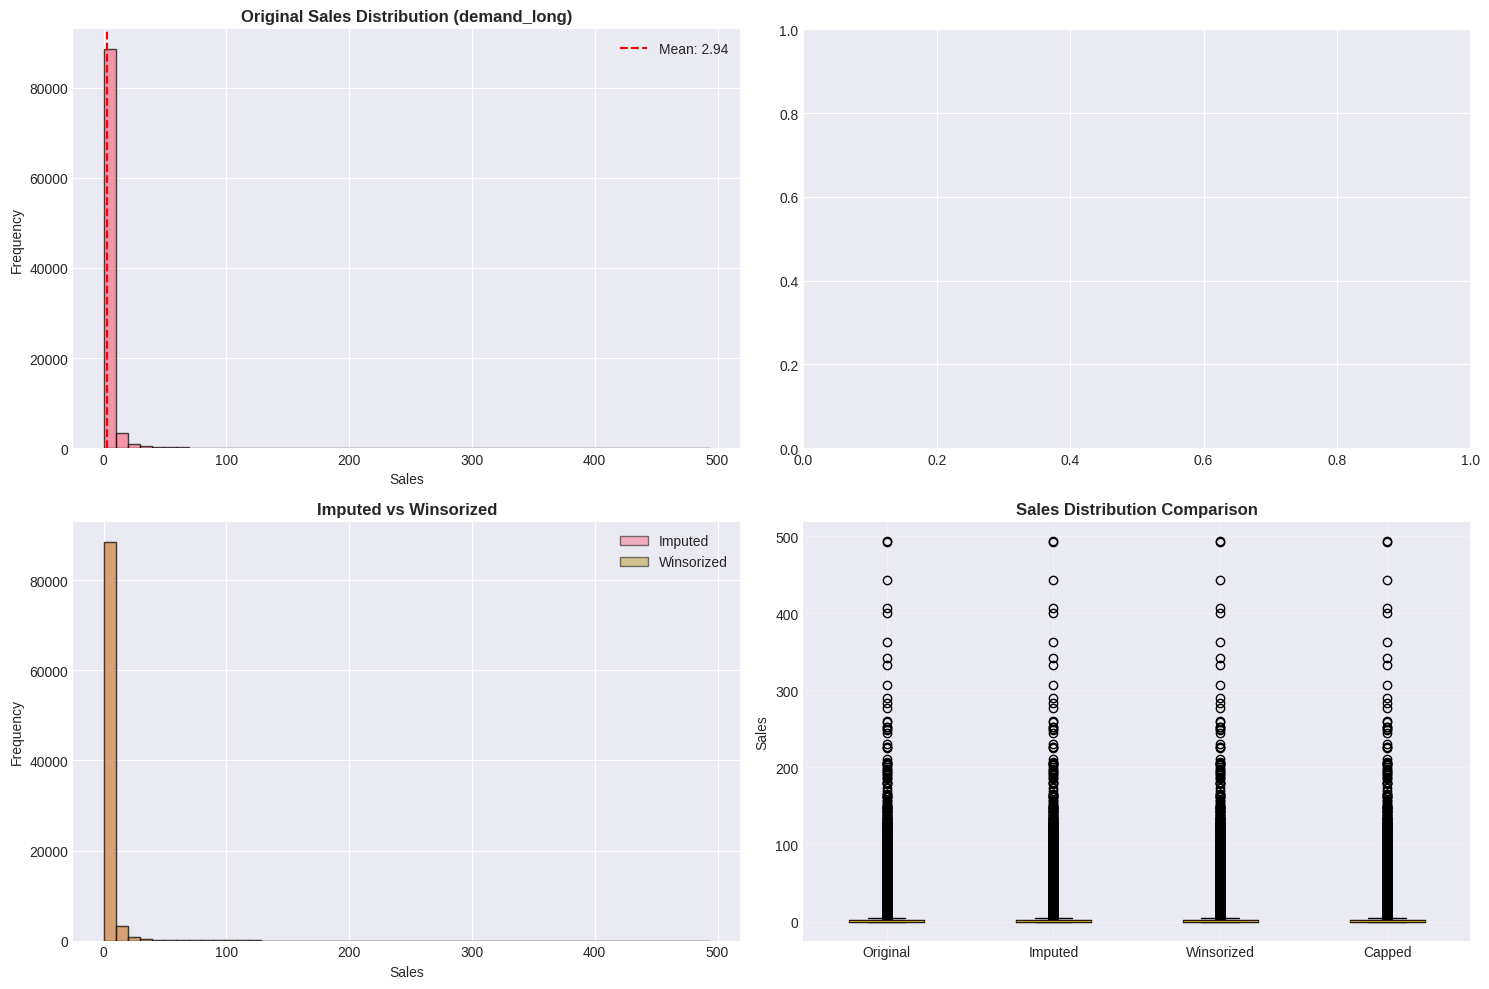


📈 Distribution Statistics:


,Original,Imputed,Winsorized,Capped
count,94043.00,94043.00,94043.00,94043.00
mean,2.94,2.94,2.94,2.94
std,10.43,10.43,10.43,10.43
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00
50%,1.00,1.00,1.00,1.00
75%,2.00,2.00,2.00,2.00
max,494.00,494.00,494.00,494.00


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Original sales distribution (demand_long)
axes[0, 0].hist(demand_long['sales'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Original Sales Distribution (demand_long)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Sales')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(demand_long['sales'].mean(), color='red', linestyle='--', label=f'Mean: {demand_long["sales"].mean():.2f}')
axes[0, 0].legend()

# 2. Imputed sales distribution
if 'imputed' in demand_imputed.columns and demand_imputed['imputed'].any():
    original_sales = demand_imputed[~demand_imputed['imputed']]['sales']
    imputed_sales = demand_imputed[demand_imputed['imputed']]['sales']
    
    axes[0, 1].hist(original_sales, bins=50, alpha=0.5, label='Original', edgecolor='black')
    axes[0, 1].hist(imputed_sales, bins=50, alpha=0.5, label='Imputed', edgecolor='black')
    axes[0, 1].set_title('Original vs Imputed Sales', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Sales')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()

# 3. Winsorized comparison
axes[1, 0].hist(demand_imputed['sales'], bins=50, alpha=0.5, label='Imputed', edgecolor='black')
axes[1, 0].hist(demand_winsor['sales'], bins=50, alpha=0.5, label='Winsorized', edgecolor='black')
axes[1, 0].set_title('Imputed vs Winsorized', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Sales')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# 4. Box plot comparison
data_to_plot = [
    demand_long['sales'],
    demand_imputed['sales'],
    demand_winsor['sales'],
    demand_capped['sales']
]
axes[1, 1].boxplot(data_to_plot, labels=['Original', 'Imputed', 'Winsorized', 'Capped'])
axes[1, 1].set_title('Sales Distribution Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Sales')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Distribution Statistics:")
print("=" * 70)
summary = pd.DataFrame({
    'Original': demand_long['sales'].describe(),
    'Imputed': demand_imputed['sales'].describe(),
    'Winsorized': demand_winsor['sales'].describe(),
    'Capped': demand_capped['sales'].describe()
})
display(summary)

## 9. Data Integrity Checks

Verify no data corruption or anomalies.

In [13]:
print("🔍 Data Integrity Checks")
print("=" * 70)

# Check 1: No missing values in critical columns
critical_cols = ['Store', 'Product', 'sales', 'week', 'week_date']
missing = demand_long[critical_cols].isnull().sum()
print(f"✓ Missing values in critical columns:")
for col in critical_cols:
    if col in demand_long.columns:
        n_missing = missing[col]
        if n_missing == 0:
            print(f"  {col:15s}: ✅ None")
        else:
            print(f"  {col:15s}: ⚠️  {n_missing:,}")

# Check 2: No duplicate SKU-week pairs
duplicates = demand_long.duplicated(subset=['Store', 'Product', 'week']).sum()
if duplicates == 0:
    print(f"\n✅ No duplicate SKU-week pairs")
else:
    print(f"\n⚠️  Found {duplicates:,} duplicate SKU-week pairs!")

# Check 3: Sales are non-negative
negative_sales = (demand_long['sales'] < 0).sum()
if negative_sales == 0:
    print(f"✅ All sales values are non-negative")
else:
    print(f"⚠️  Found {negative_sales:,} negative sales values!")

# Check 4: Week sequence is continuous per SKU
print(f"\n✓ Week continuity check:")
for (store, product), group in demand_long.groupby(['Store', 'Product']):
    weeks = sorted(group['week'].unique())
    expected = list(range(min(weeks), max(weeks) + 1))
    if weeks != expected:
        missing_weeks = set(expected) - set(weeks)
        print(f"  ⚠️  Store {store}, Product {product}: Missing weeks {missing_weeks}")
        break
else:
    print(f"  ✅ All SKUs have continuous week sequences")

# Check 5: Imputed data has same shape
print(f"\n✓ Shape consistency:")
print(f"  demand_long: {demand_long.shape}")
print(f"  demand_imputed: {demand_imputed.shape}")
print(f"  demand_winsor: {demand_winsor.shape}")
print(f"  demand_capped: {demand_capped.shape}")

if (demand_long.shape[0] == demand_imputed.shape[0] == 
    demand_winsor.shape[0] == demand_capped.shape[0]):
    print(f"  ✅ All processed files have same number of rows")
else:
    print(f"  ⚠️  Row counts differ across files!")

print("\n" + "=" * 70)

🔍 Data Integrity Checks
✓ Missing values in critical columns:
  Store          : ✅ None
  Product        : ✅ None
  sales          : ✅ None
  week           : ✅ None
  week_date      : ✅ None

✅ No duplicate SKU-week pairs
✅ All sales values are non-negative

✓ Week continuity check:


TypeError: can only concatenate str (not "int") to str

## 10. Detailed SKU-Level Validation

Inspect a few representative SKUs to verify correctness.

In [ ]:
# Pick a representative SKU with stockouts
sku_with_stockout = demand_long[~demand_long['in_stock']].groupby(['Store', 'Product']).size().idxmax()
store, product = sku_with_stockout

print(f"📦 Detailed validation for Store={store}, Product={product}")
print("=" * 70)

# Get this SKU's data across all versions
sku_long = demand_long[(demand_long['Store']==store) & (demand_long['Product']==product)].copy()
sku_imputed = demand_imputed[(demand_imputed['Store']==store) & (demand_imputed['Product']==product)].copy()

print(f"Total weeks: {len(sku_long)}")
print(f"Stockouts: {(~sku_long['in_stock']).sum()} weeks")
print(f"Mean sales (original): {sku_long['sales'].mean():.2f}")
print(f"Mean sales (imputed): {sku_imputed['sales'].mean():.2f}")

# Show recent history with stockouts
print(f"\n📅 Last 20 weeks with stockout flags:")
display(sku_long[['week_date', 'sales', 'in_stock']].tail(20))

# Plot this SKU's time series
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Original
axes[0].plot(sku_long['week_date'], sku_long['sales'], marker='o', label='Original', alpha=0.7)
stockout_weeks = sku_long[~sku_long['in_stock']]
axes[0].scatter(stockout_weeks['week_date'], stockout_weeks['sales'], 
               color='red', s=100, marker='x', label='Stockout', zorder=5)
axes[0].set_title(f'Store {store}, Product {product} - Original Sales', fontweight='bold')
axes[0].set_ylabel('Sales')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Imputed
axes[1].plot(sku_imputed['week_date'], sku_imputed['sales'], marker='o', label='Imputed', alpha=0.7)
if 'imputed' in sku_imputed.columns:
    imputed_weeks = sku_imputed[sku_imputed['imputed']]
    axes[1].scatter(imputed_weeks['week_date'], imputed_weeks['sales'], 
                   color='green', s=100, marker='s', label='Imputed Value', zorder=5)
axes[1].set_title(f'Store {store}, Product {product} - After Imputation', fontweight='bold')
axes[1].set_xlabel('Week')
axes[1].set_ylabel('Sales')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Generate Validation Summary Report

Create comprehensive summary of all validation checks.

In [ ]:
validation_results = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'raw_data': {
        'n_skus': len(idx),
        'n_weeks': len(date_cols),
        'total_sales': float(sales_raw[date_cols].sum().sum()),
        'date_range': f"{date_cols[0]} to {date_cols[-1]}"
    },
    'interim_data': {
        'state_shape': state_interim.shape,
        'master_shape': master_interim.shape,
        'total_inventory': float(state_interim['on_hand'].sum())
    },
    'processed_data': {
        'demand_long_shape': demand_long.shape,
        'n_observations': len(demand_long),
        'n_skus': len(demand_long.groupby(['Store', 'Product'])),
        'n_weeks': demand_long['week'].nunique(),
        'total_sales': float(demand_long['sales'].sum()),
        'stockout_rate': float((~demand_long['in_stock']).mean() * 100),
        'n_stockouts': int((~demand_long['in_stock']).sum())
    },
    'imputation': {
        'demand_imputed_shape': demand_imputed.shape,
        'demand_winsor_shape': demand_winsor.shape,
        'demand_capped_shape': demand_capped.shape,
        'imputation_rate': float(demand_imputed['imputed'].mean() * 100) if 'imputed' in demand_imputed.columns else None,
        'n_imputed': int(demand_imputed['imputed'].sum()) if 'imputed' in demand_imputed.columns else 0,
        'mean_sales_original': float(demand_long['sales'].mean()),
        'mean_sales_imputed': float(demand_imputed['sales'].mean()),
        'mean_sales_winsor': float(demand_winsor['sales'].mean()),
        'mean_sales_capped': float(demand_capped['sales'].mean())
    },
    'validation_checks': {
        'row_count_match': len(demand_long) == len(demand_imputed),
        'no_missing_critical': demand_long[['Store', 'Product', 'sales']].isnull().sum().sum() == 0,
        'no_duplicates': demand_long.duplicated(subset=['Store', 'Product', 'week']).sum() == 0,
        'no_negative_sales': (demand_long['sales'] >= 0).all(),
        'sales_total_match': abs(sales_raw[date_cols].sum().sum() - demand_long['sales'].sum()) < 1,
        'stockout_sales_zero': len(demand_long[~demand_long['in_stock'] & (demand_long['sales'] > 0)]) == 0,
        'imputation_complete': (demand_imputed['imputed'].sum() > 0) if 'imputed' in demand_imputed.columns else False
    }
}

print("\n" + "="*70)
print("📋 VALIDATION SUMMARY REPORT")
print("="*70)

for category, data in validation_results.items():
    if category == 'timestamp':
        print(f"\n⏰ Generated: {data}")
    elif category == 'validation_checks':
        print(f"\n✅ Validation Checks:")
        for check, passed in data.items():
            status = "✅ PASS" if passed else "❌ FAIL"
            print(f"  {check:25s}: {status}")
    else:
        print(f"\n📊 {category.replace('_', ' ').title()}:")
        for key, value in data.items():
            if isinstance(value, float):
                print(f"  {key:25s}: {value:,.2f}")
            elif isinstance(value, tuple):
                print(f"  {key:25s}: {value}")
            else:
                print(f"  {key:25s}: {value:,}" if isinstance(value, int) else f"  {key:25s}: {value}")

# Check if all validations passed
all_passed = all(validation_results['validation_checks'].values())
print("\n" + "="*70)
if all_passed:
    print("🎉 ALL VALIDATION CHECKS PASSED! Data is ready for model training.")
else:
    print("⚠️  VALIDATION FAILED! Review the issues above before proceeding.")
    print("\n🔴 Critical Issues:")
    for check, passed in validation_results['validation_checks'].items():
        if not passed:
            print(f"   - {check.replace('_', ' ').title()}")
print("="*70)

In [ ]:
# Save validation results to file
import json

validation_file = Path('../data/processed/validation_results.json')
with open(validation_file, 'w') as f:
    json.dump(validation_results, f, indent=2)

print(f"\n💾 Validation results saved to: {validation_file}")

# Also create a markdown summary
summary_md = f"""# Data Validation Results

**Generated**: {validation_results['timestamp']}

## Summary

{"✅ **Status**: ALL CHECKS PASSED" if all_passed else "❌ **Status**: VALIDATION FAILED"}

## Data Pipeline Overview

### Raw Data
- SKUs: {validation_results['raw_data']['n_skus']:,}
- Weeks: {validation_results['raw_data']['n_weeks']}
- Total Sales: {validation_results['raw_data']['total_sales']:,.0f} units
- Date Range: {validation_results['raw_data']['date_range']}

### Processed Data
- Observations: {validation_results['processed_data']['n_observations']:,}
- SKUs: {validation_results['processed_data']['n_skus']:,}
- Weeks: {validation_results['processed_data']['n_weeks']}
- Stockout Rate: {validation_results['processed_data']['stockout_rate']:.1f}% ({validation_results['processed_data']['n_stockouts']:,} observations)

### Imputation
- Imputed Observations: {validation_results['imputation']['n_imputed']:,}
- Imputation Rate: {validation_results['imputation']['imputation_rate'] if validation_results['imputation']['imputation_rate'] is not None else 0:.1f}%
- Mean Sales (Original): {validation_results['imputation']['mean_sales_original']:.2f}
- Mean Sales (Imputed): {validation_results['imputation']['mean_sales_imputed']:.2f}
- Mean Sales (Winsorized): {validation_results['imputation']['mean_sales_winsor']:.2f}

## Validation Checks

"""

for check, passed in validation_results['validation_checks'].items():
    status = "✅ PASS" if passed else "❌ FAIL"
    summary_md += f"- **{check.replace('_', ' ').title()}**: {status}\n"

if not all_passed:
    summary_md += f"""
## 🚨 Critical Issues Found

"""
    for check, passed in validation_results['validation_checks'].items():
        if not passed:
            summary_md += f"### {check.replace('_', ' ').title()}\n\n"
            if check == 'imputation_complete':
                summary_md += f"""**Problem**: Imputation has not been run or failed to complete.

**Evidence**:
- Expected imputed observations: ~{validation_results['processed_data']['n_stockouts']:,} (matching stockout rate)
- Actual imputed observations: {validation_results['imputation']['n_imputed']:,}
- Imputation rate: {validation_results['imputation']['imputation_rate'] if validation_results['imputation']['imputation_rate'] is not None else 0:.1f}%

**Solution**:
```bash
./go impute --n-neighbors 20 --n-jobs -1
```

This will:
1. Load demand_long.parquet with stockout flags
2. Use K-nearest neighbors to impute censored demand
3. Generate quantile forecasts for {validation_results['processed_data']['n_stockouts']:,} stockout observations
4. Save results to demand_imputed.parquet with 'imputed' flag set

After running, re-validate using this notebook.

"""

summary_md += f"""
## Next Steps

"""

if all_passed:
    summary_md += """The data has passed all validation checks and is ready for Phase 4: Model Training!

Run:
```bash
./go forecast --config configs/forecast.yaml --n-jobs 12
```
"""
else:
    summary_md += """⚠️ **DO NOT PROCEED TO MODEL TRAINING YET!**

Fix the issues above first:

1. **Run imputation** (if imputation_complete failed):
   ```bash
   ./go impute --n-neighbors 20 --n-jobs -1
   ```

2. **Re-run this validation notebook** to verify fixes

3. **Then proceed to model training**:
   ```bash
   ./go forecast --config configs/forecast.yaml --n-jobs 12
   ```
"""

summary_file = Path('../DATA_VALIDATION_RESULTS.md')
with open(summary_file, 'w') as f:
    f.write(summary_md)

print(f"📄 Summary report saved to: {summary_file}")
print(f"\n✨ Data validation complete! Check {summary_file} for full report.")

if not all_passed:
    print(f"\n🔴 ATTENTION: Validation failures detected! Review report before proceeding.")